## Supervised Learning: Challenge

In this challenge, we will try to predict credit card fraud.

Download the data from [here](https://drive.google.com/file/d/1FCQY1SiWIjh_ME6Wtb3FG8Y1sKoRwAUc/view?usp=sharing). The data is originally from a [Kaggle Competition](https://www.kaggle.com/mlg-ulb/creditcardfraud).

The dataset contains transactions made by credit cards within two days in September 2013 by European cardholders.  Where **we have 492 occurrences of fraud out of the total of 284,807 transactions**. This dataset is highly unbalanced, with the positive class (frauds) account for 0.172% of all transactions.

In [107]:
#import libraries

#base libraries
import pandas as pd
import numpy as np

#plot libraries
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

#Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score, roc_auc_score

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
#import dataset
credit = pd.read_csv('creditcard.csv')
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
#check shape
credit.shape

(284807, 31)

In [6]:
#check for missing values
credit.isnull().sum().max()

0

In [8]:
#check classes
credit['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Data is heavily skewed, will need to standardize later

____________________
### **Challenge:** Identify fraudulent credit card transactions.

Features V1, V2, … V28 are the principal components obtained with PCA. The only features that are not transformed with PCA are `'Time'` and `'Amount'`.  

- The feature `'Time'` contains the seconds elapsed between each transaction and the first transaction in the dataset.
- The feature `'Amount'` is the transaction amount; this feature can be used for example-dependant cost-sensitive learning. 
- The feature `'Class'` is the target variable, and it takes the value of 1 in case of fraud and 0 otherwise.

> #### Warning
> There is a huge class imbalance ratio, so we need to be careful when evaluating. It might be better to use the method `.predict_proba()` with a custom cut-off to search for fraudulent transactions.

### EDA and Feature Selection

Text(0.5, 1.0, 'Class Distributions \n (0 = No Fraud | 1 = Fraud)')

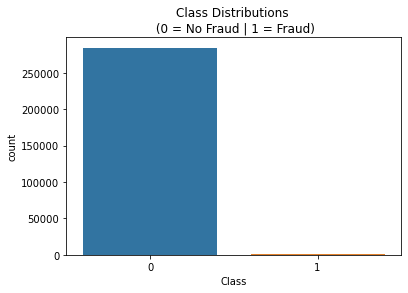

In [15]:
#visualize skewness
sns.countplot('Class', data = credit)
plt.title('Class Distributions \n (0 = No Fraud | 1 = Fraud)')

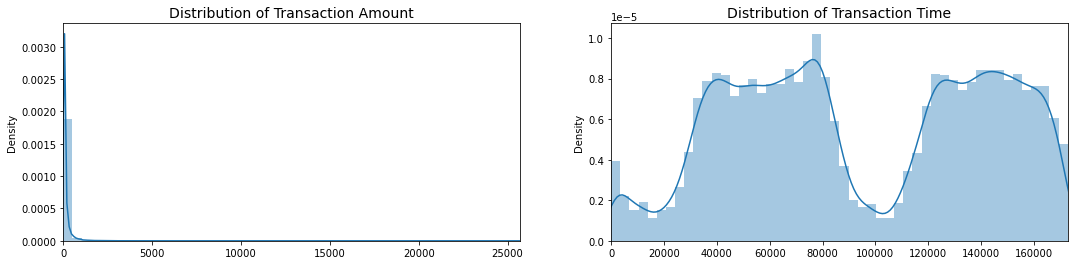

In [20]:
#create plots to see both time and amount histograpms
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = credit['Amount'].values
time_val = credit['Time'].values

sns.distplot(amount_val, ax=ax[0])
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1])
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

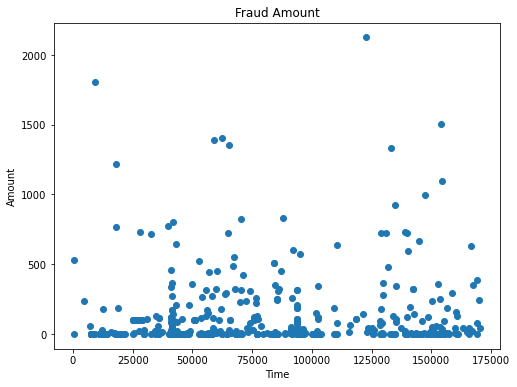

In [23]:
#let us look more closely to transaction amount and time for fraud cases
credit_fraud = credit[credit['Class'] == 1] #retrieve only fraud data

#create plot
plt.figure(figsize=(8,6))
plt.scatter(credit_fraud.Time, credit_fraud.Amount)
plt.title('Fraud Amount')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.show()

Majority of fraud done are small amounts

In [28]:
#amount of fraud over 1000 dollars is
credit_fraud[credit_fraud['Amount'] > 1000].shape[0]

9

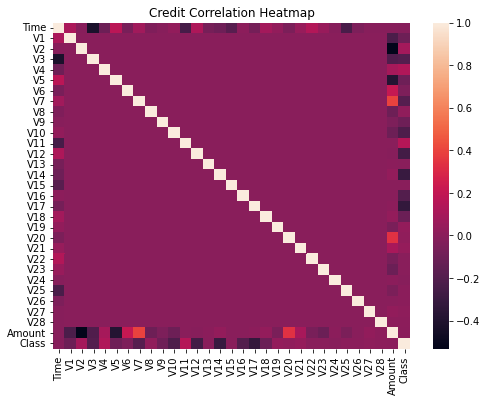

In [30]:
#since PCA was done, let us see correlation
credit_corr = credit.corr()

plt.figure(figsize=(8,6))
sns.heatmap(credit_corr)
plt.title('Credit Correlation Heatmap')
plt.show()

Many features are not correlated with each other.

Although dimension reduction can be beneficial if correclty picking the features

In [35]:
#let us see the correlation coeffiecients
rank = credit_corr['Class'] #retrieve coef of each feature related to class

#create DF
df_rank = pd.DataFrame(rank)

#find aboslute values and rank
np.abs(df_rank).sort_values(by='Class', ascending = False).head(10)

,Class
Class,1.000000
V17,0.326481
V14,0.302544
V12,0.260593
V10,0.216883
V16,0.196539
V3,0.192961
V7,0.187257
V11,0.154876
V4,0.133447


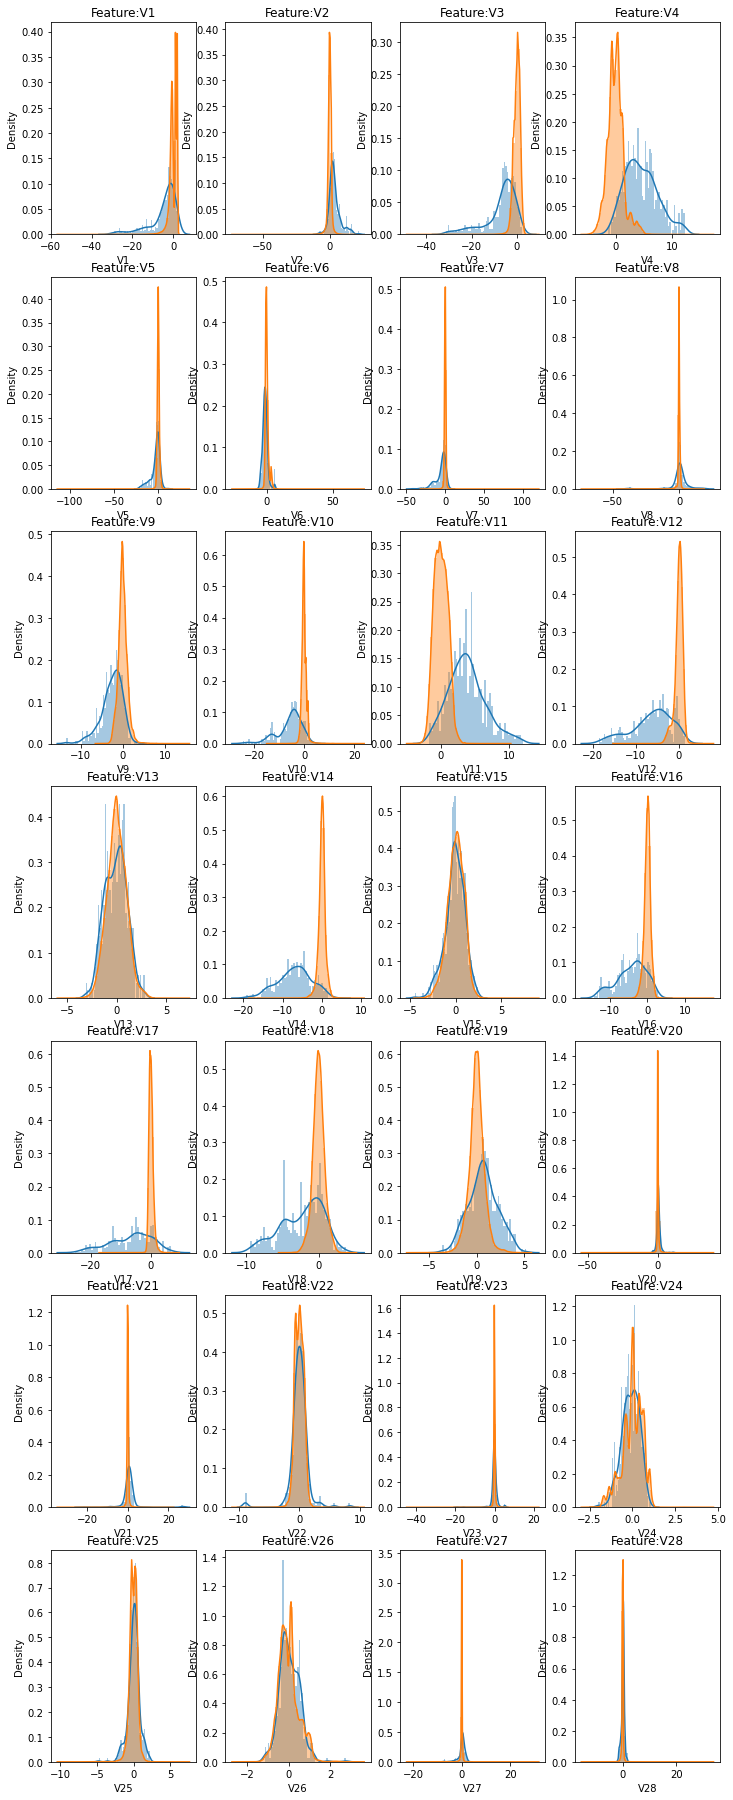

In [40]:
#let us view the PCA components in more detail
features = credit.iloc[:,1:29].columns

#create subplots
plt.figure(figsize = (12,8*4))
gs = GridSpec(7,4)

for index, col in enumerate(credit[features]):
    fig = plt.subplot(gs[index])
    sns.distplot(credit[col][credit.Class == 1], bins = 50) #one plot for fraud
    sns.distplot(credit[col][credit.Class == 0], bins = 50) #non-fraud
    fig.set_title('Feature:' + str(col))
plt.show()

I want to also use RandomForestClassifer to verify this and select important features

In [48]:
#instantiate classifer
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)

#just using main dataframe
rfc.fit(credit.iloc[:,1:29], credit.iloc[:,30])

rfc_data = {'Features': credit.iloc[:,1:29].columns, 'Importance':rfc.feature_importances_}
rfc_data = pd.DataFrame(rfc_data)
rfc_data.head()

,Features,Importance
0,V1,0.016479
1,V2,0.013453
2,V3,0.017137
3,V4,0.024409
4,V5,0.013344


In [56]:
#check shape
rfc_data.shape

(28, 2)

In [59]:
#print most important features
for feature, importance in zip(credit.iloc[:,1:29].columns, rfc.feature_importances_):
    if importance >= 0.02:
        print(feature)

V4
V7
V9
V10
V11
V12
V14
V16
V17
V18
V21


In [64]:
#drop all unimportant features
new_credit = credit[['Time', 'Amount','V4','V7','V9','V10','V11','V12',
                     'V14','V16','V17', 'V18', 'V21', 'Class']]


#instantiate scaler
std_scalar = StandardScaler()

#scale time and amount columns
new_credit['Amount'] = std_scalar.fit_transform(new_credit['Amount'].values.reshape(-1,1))
new_credit['Time'] = std_scalar.fit_transform(new_credit['Time'].values.reshape(-1,1))

#print new data frame
new_credit.head()

,Time,Amount,V4,V7,V9,V10,V11,V12,V14,V16,V17,V18,V21,Class
0,-1.996583,0.244964,1.378155,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,-0.018307,0
1,-1.996583,-0.342475,0.448154,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.225775,0
2,-1.996562,1.160686,0.379780,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,0.247998,0
3,-1.996562,0.140534,-0.863291,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-0.108300,0
4,-1.996541,-0.073403,0.403034,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,-0.009431,0


### Now classifiers

In [67]:
#define X and y
X = new_credit.drop(['Class'], axis = 1)
y = new_credit['Class']

#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True, 
                                                    train_size=0.80,
                                                   random_state=42)

#Check number of samples
print(f'{len(X_train)} training samples and {len(X_test)} test samples for X')
print(f'{len(y_train)} training samples and {len(y_test)} test samples for y')

227845 training samples and 56962 test samples for X
227845 training samples and 56962 test samples for y


In [94]:
#define function to get predictions for each model
def predictions(model, X_train, y_train, X_test):
    #make classifier
    model = model
    #fit to training data
    model.fit(X_train, y_train)
    #predict and precicted probabilities
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    
    return y_pred , y_prob

#function to print scores
def print_scores(y_test,y_pred,y_pred_prob):
    print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred)) 
    print("recall score: ", recall_score(y_test,y_pred))
    print("precision score: ", precision_score(y_test,y_pred))
    print("f1 score: ", f1_score(y_test,y_pred))
    print("accuracy score: ", accuracy_score(y_test,y_pred))
    print("ROC AUC: {}".format(roc_auc_score(y_test, y_prob[:,1])))

In [95]:
#First the gaussian NB model

#instantiate model
GNB = GaussianNB()

#run through predictions, had to change print aoc y_prob[:,1]
y_pred , y_prob = predictions(GNB, X_train, y_train, X_test)
print_scores(y_test, y_pred , y_prob)

test-set confusion matrix:
 [[56246   618]
 [   14    84]]
recall score:  0.8571428571428571
precision score:  0.11965811965811966
f1 score:  0.21
accuracy score:  0.9889048839577262
ROC AUC: 0.9591653698620699


In [97]:
#Second the Bernoulli NB model - multivariate

#instantiate model
BNB = BernoulliNB()

#run through predictions, had to change print aoc y_prob[:,1]
y_pred , y_prob = predictions(BNB, X_train, y_train, X_test)
print_scores(y_test, y_pred , y_prob)

test-set confusion matrix:
 [[56855     9]
 [   81    17]]
recall score:  0.17346938775510204
precision score:  0.6538461538461539
f1 score:  0.27419354838709675
accuracy score:  0.9984199992977775
ROC AUC: 0.9654482625211029


In [103]:
#Third the SVC model 

#instantiate model
svc = SVC(gamma='auto', kernel = 'linear', 
          probability = True, random_state=42) #probability needs to equal true for y_prob

#run through predictions, had to change print aoc y_prob[:,1]
y_pred , y_prob = predictions(svc, X_train, y_train, X_test)
print_scores(y_test, y_pred , y_prob)

test-set confusion matrix:
 [[56850    14]
 [   22    76]]
recall score:  0.7755102040816326
precision score:  0.8444444444444444
f1 score:  0.8085106382978723
accuracy score:  0.9993679997191109
ROC AUC: 0.9574882569797756


In [105]:
#Lets retry forest

#instantiate classifer
rfc2 = RandomForestClassifier(n_estimators = 100, random_state = 42)

#run through predictions, had to change print aoc y_prob[:,1]
y_pred , y_prob = predictions(rfc2, X_train, y_train, X_test)
print_scores(y_test, y_pred , y_prob)

test-set confusion matrix:
 [[56861     3]
 [   21    77]]
recall score:  0.7857142857142857
precision score:  0.9625
f1 score:  0.8651685393258427
accuracy score:  0.9995786664794073
ROC AUC: 0.9529896968635513


In [104]:
#total non-fraud and fraud
print('The number of non-fraud transactions is:', credit[credit['Class'] == 0].shape[0])
print('The number of fraud transactions is:', credit[credit['Class'] == 1].shape[0])

The number of non-fraud transactions is: 284315
The number of fraud transactions is: 492


## Extra Misc Code and using gridsearch

Found this code on kaggle and wanted to try running it

https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets

Deals with imbalanced datasets and dealing with unbalanceed and balanced data

In [110]:
#define simple classifiers
classifiers = {
    "Gaussen": GaussianNB(),
    "Bernoulli": BernoulliNB(),
    "Support Vector Classifier": SVC(),
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Forest Classifier": RandomForestClassifier()
}

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, 
          "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  GaussianNB Has a training score of 99.0 % accuracy score
Classifiers:  BernoulliNB Has a training score of 100.0 % accuracy score
Classifiers:  SVC Has a training score of 100.0 % accuracy score
Classifiers:  LogisticRegression Has a training score of 100.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 100.0 % accuracy score
Classifiers:  RandomForestClassifier Has a training score of 100.0 % accuracy score


In [113]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression gridsearch
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
log_reg = grid_log_reg.best_estimator_ # get the best parameters.


# Logistic Regression gridsearch
ber_params = {'fit_prior':['True', 'False']}
grid_ber = GridSearchCV(BernoulliNB(), ber_params)
grid_ber.fit(X_train, y_train)
ber_neighbors = grid_ber.best_estimator_


In [114]:
# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
svc = grid_svc.best_estimator_

In [115]:
%time
# RandomForest Classifier
tree_params = {"max_depth": [2,3,4], "min_samples_leaf": [4,5,6]}
grid_tree = GridSearchCV(RandomForestClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
tree_clf = grid_tree.best_estimator_

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 13.8 µs


In [119]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

ber_score = cross_val_score(ber_neighbors, X_train, y_train, cv=5)
print('Bernoulli NB Cross Validation Score', round(ber_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('RandomForest Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  99.92%
Bernoulli NB Cross Validation Score 99.87%
Support Vector Classifier Cross Validation Score 99.95%
RandomForest Classifier Cross Validation Score 99.94%


In [127]:
from sklearn.model_selection import StratifiedShuffleSplit as sss
from imblearn.under_sampling import NearMiss

# We will undersample during cross validating
undersample_X = new_credit.drop('Class', axis=1)
undersample_y = new_credit['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))

# Cross Validating the right way
for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

TypeError: split() missing 1 required positional argument: 'y'

The NearMiss Algorithm has undersampled the majority instances and made it equal to majority class. Here, the majority class has been reduced to the total number of minority class, so that both classes will have equal number of records.

In [124]:
# Let's Plot LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Bernoulli NB Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Random Forest Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

KeyboardInterrupt: 

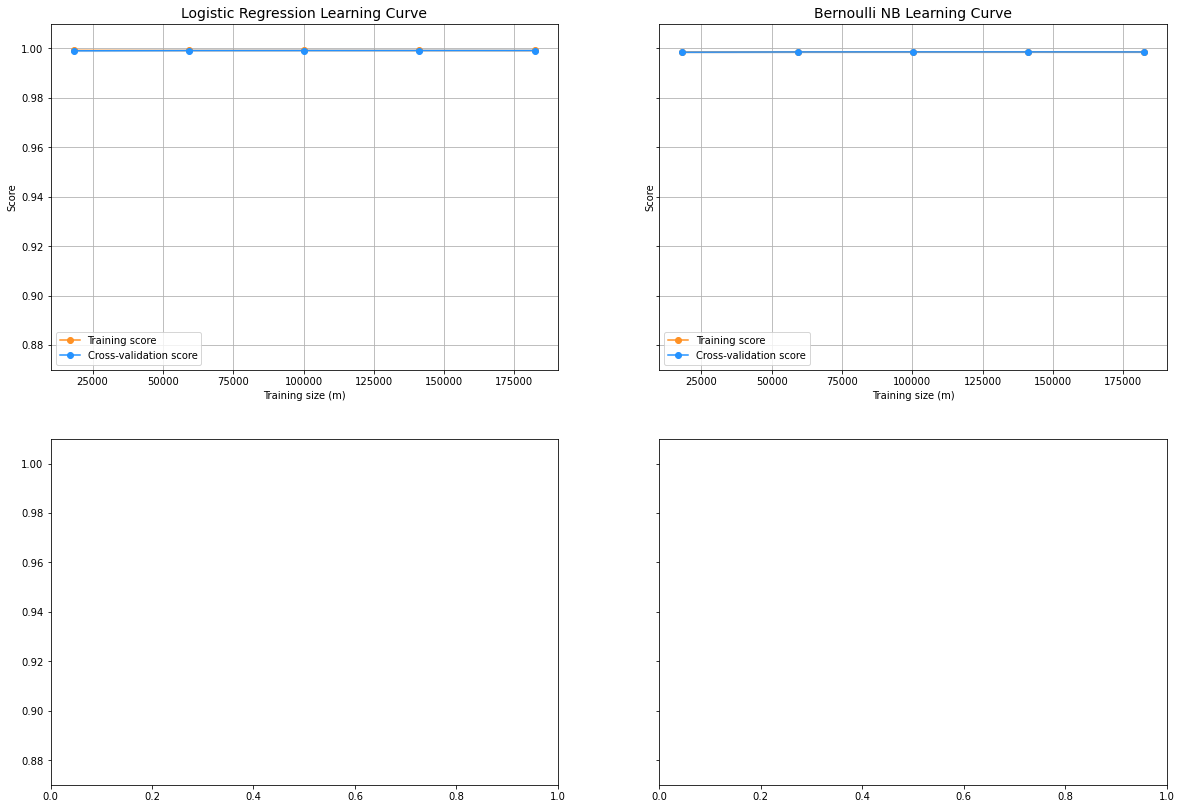

In [128]:
#plot
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, ber_neighbors, svc, tree_clf, 
                    X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

# Create a DataFrame with all the scores and the classifiers names.
log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

ber_pred = cross_val_predict(ber_neighbors, X_train, y_train, cv=5,
                            method="decision_function")

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('Bernoulli NB: ', roc_auc_score(y_train, ber_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Random Forest Classifier: ', roc_auc_score(y_train, tree_pred))

In [ ]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
ber_fpr, ber_tpr, ber_threshold = roc_curve(y_train, ber_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, ber_fpr, ber_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(ber_fpr, ber_tpr, label='Bernoulli NB Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='RandomForest Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, ber_fpr, ber_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

In [ ]:
undersample_y_score = log_reg.decision_function(original_Xtest)

from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))